In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

# Import Data

In [3]:
df = pd.read_csv("data_text/df_cleaning1.csv")
df.head()

,label,fitur
0,1,pemakaian masker menyebabkan penyakit legionna...
1,1,instruksi gubernur jateng tentang penilangan b...
2,1,foto jim rohn jokowi adalah presiden terbaik d...
3,1,ini bukan politik tapi kenyataan pak jokowi be...
4,1,foto kadrun kalo lihat foto ini panas dingin k...


# Dataset Splitting

In [4]:
X = df.fitur
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3384,), (847,), (3384,), (847,))

# Training

In [78]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.ensemble import VotingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

In [95]:
pipeline1 = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

pipeline2 = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

pipeline3 = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

pipeline4 = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('algo', SVC(max_iter=500))
])

model1 = RandomizedSearchCV(pipeline1, rsp.rf_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model2 = RandomizedSearchCV(pipeline2, rsp.xgb_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model3 = RandomizedSearchCV(pipeline3, rsp.logreg_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model4 = RandomizedSearchCV(pipeline3, rsp.svm_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)

model_voting = VotingClassifier(
    estimators=[
        ('clf1', model1),
        ('clf2', model2),
        ('clf3', model3),
        ('clf4', model4)
    ])
     
model_voting.fit(X_train, y_train)

print(model_voting.score(X_train, y_train), model_voting.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.4min finished
C:\Users\Yulika\anaconda3\envs\jcopdl\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
C:\Users\Yulika\anaconda3\envs\jcopdl\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   40.1s finished
C:\Users\Yulika\anaconda3\envs\jcopdl\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: Invalid parameter gamma for estimator LogisticRegression(C=0.17670169402947963, n_jobs=-1, random_state=42). Check the list of available parameters with `estimator.get_params().keys()`.

# Prediksi

In [80]:
y_pred = model_voting.predict(X_test)

# Evaluasi

In [81]:
from sklearn.metrics import classification_report, f1_score

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.26      0.39       153
           1       0.86      0.98      0.92       694

    accuracy                           0.85       847
   macro avg       0.81      0.62      0.65       847
weighted avg       0.84      0.85      0.82       847



In [83]:
print(f1_score(y_test, y_pred))

0.9160510409670921


In [84]:
from jcopml.plot import plot_confusion_matrix

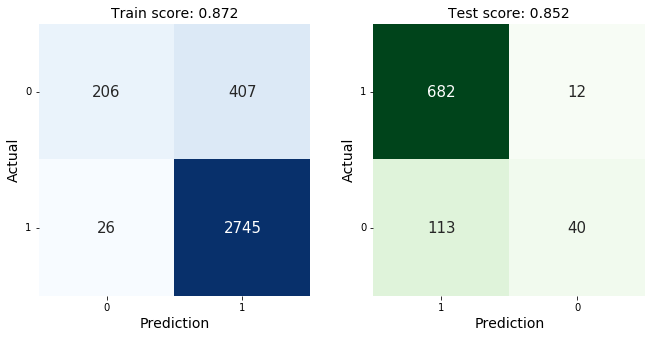

In [85]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model_voting)

# Uji Data Test

In [86]:
import xlrd

In [87]:
df_uji = pd.read_excel("data_text/test.xlsx")
df_uji

,ID,tanggal,judul,narasi,nama file gambar
0,238057,2020-07-13 00:00:00,Narasi Tito Karnavian Berideologi Komunis Kare...,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...,238057.jpg
1,238158,2020-07-06 00:00:00,Anies: Seberat beratnya Pekerjaan Akan terasa ...,Seberat beratnya Pekerjaan Akan terasa ringan ...,238158.jpg
2,238865,2020-04-22 00:00:00,Hindu di india Melemparkan Patung Buatan Merek...,Hindu di india melemparkan patung buatan merek...,238865.jpg
3,248298,2019-10-22 00:00:00,RSCM Praktekkan Penyedotan Plug Vena/Saluran ...,Mulai Hari ini di RSCM mulai diPraktekkan Peny...,248298.jpg
4,255176,2020-05-01 00:00:00,Permohonan Kelonggaran Angsuran ke OJK,"Untuk sekedar info, Bagi anda yg punya ansuran...",255176.jpg
...,...,...,...,...,...
465,206021,2020-05-01 00:00:00,"Dijemput oleh Tim Medis, Kakak Beradik Usia 8 ...","DiTangerang, dua bersaudara kakak beradik usia...",206021.jpg
466,219874,2017-10-02 00:00:00,": Pertanda Alam, Kera Putih Mulai Turun Dari G...","Pertanda Alam, Kera Putih Mulai Turun Dari Gun...",219874.jpg
467,222802,2020-03-22 00:00:00,Pasar Wameo dan Karya Nugraha di Tutup selama ...,Assalamu Alaikum …\n \n Info dari pedagang pa...,222802.jpg
468,226020,2018-09-25 00:00:00,Klarifikasi KPK Terkait Foto Setya Novanto Tan...,Secara tidak sengaja sekitar pukul 06.00 WIB d...,226020.jpg


In [88]:
X_true_uji = df_uji["judul"] + "" + df_uji["narasi"]
X_true_uji.shape

(470,)

In [89]:
y_pred_uji = model_voting.predict(X_true_uji)

In [90]:
df_uji_true = pd.read_excel("data_text/y_true.xlsx")
df_uji_true.head()

,ID,tanggal,judul,narasi,nama file gambar,Unnamed: 5,kebenaran
0,238057,2020-07-13 00:00:00,Narasi Tito Karnavian Berideologi Komunis Kare...,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...,238057.jpg,NaN,1
1,238158,2020-07-06 00:00:00,Anies: Seberat beratnya Pekerjaan Akan terasa ...,Seberat beratnya Pekerjaan Akan terasa ringan ...,238158.jpg,NaN,1
2,238865,2020-04-22 00:00:00,Hindu di india Melemparkan Patung Buatan Merek...,Hindu di india melemparkan patung buatan merek...,238865.jpg,NaN,1
3,248298,2019-10-22 00:00:00,RSCM Praktekkan Penyedotan Plug Vena/Saluran ...,Mulai Hari ini di RSCM mulai diPraktekkan Peny...,248298.jpg,NaN,1
4,255176,2020-05-01 00:00:00,Permohonan Kelonggaran Angsuran ke OJK,"Untuk sekedar info, Bagi anda yg punya ansuran...",255176.jpg,NaN,1


In [91]:
y_true_uji = df_uji_true.kebenaran
y_true_uji.shape

(470,)

In [92]:
print(classification_report(y_true_uji, y_pred_uji))

              precision    recall  f1-score   support

           0       0.78      0.39      0.52        72
           1       0.90      0.98      0.94       398

    accuracy                           0.89       470
   macro avg       0.84      0.68      0.73       470
weighted avg       0.88      0.89      0.87       470



In [93]:
print(f1_score(y_true_uji, y_pred_uji))

0.9374999999999999


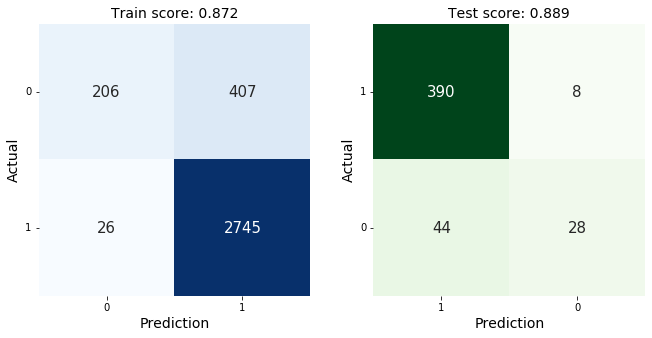

In [94]:
plot_confusion_matrix(X_train, y_train, X_true_uji, y_true_uji, model_voting)